In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
# install sqlalchemy to .venv, as it is not installed on system
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)
inspector.get_columns("measurement")

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# Viewing csv, Measurement has a "date" column, station does not.
most_recent_measurement_date = (
    session.query(Measurement.date).order_by(Measurement.date.desc()).first()
)
most_recent_measurement_date

('2017-08-23',)

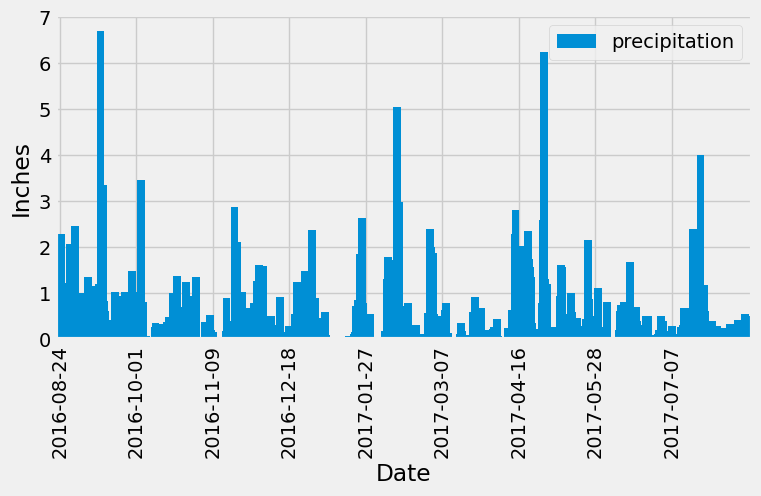

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
date_format = "%Y-%m-%d"
most_recent_date = dt.datetime.strptime(most_recent_measurement_date[0], date_format)

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

measurement_columns = [Measurement.date, Measurement.prcp]

# Perform a query to retrieve the data and precipitation scores
prev_year_query = (
    session.query(*measurement_columns).filter(Measurement.date > one_year_ago).all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prev_year_df = pd.DataFrame(prev_year_query, columns=["date", "precipitation"])
# prev_year_df['date'] = pd.to_datetime(prev_year_df['date'] )

# Sort the dataframe by date
sorted_by_date = prev_year_df.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
sorted_by_date.plot(kind="bar", x="date", y="precipitation", width=25, figsize=(8, 4))
plt.locator_params(nbins=9)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(loc="upper right")

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_by_date.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Station.station).distinct().count()
num_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# order_by agg column pulled from https://stackoverflow.com/questions/5973553/sqlalchemy-ordering-by-count-on-a-many-to-many-relationship
station_activity_freq = (
    session.query(
        *[Measurement.station, func.count(Measurement.station).label("count")]
    )
    .group_by(Measurement.station)
    .order_by(text("count DESC"))
    .all()
)
station_activity_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
most_active = session.query(*[Measurement.station, 
                              func.count(Measurement.station).label("count")]).\
    group_by(Measurement.station).\
    order_by(text("count DESC")).\
    first()
most_active = most_active[0]


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_max_avg_temp = session.query(*[func.min(Measurement.tobs).label("min"),
                                   func.max(Measurement.tobs).label("max"),
                                   func.avg(Measurement.tobs).label("avg")]).\
                            filter(Measurement.station == "USC00519281").\
                            first()
min_max_avg_temp

(54.0, 85.0, 71.66378066378067)

Text(0.5, 0, 'Temperature')

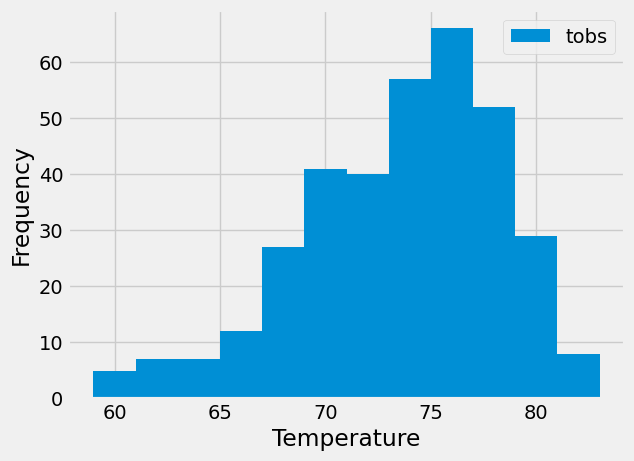

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month_temp = (
    session.query(Measurement.tobs)
    .filter(Measurement.date > one_year_ago)
    .filter(Measurement.station == "USC00519281")
    .all()
)
twelve_month_temp_df = pd.DataFrame(twelve_month_temp, columns=["tobs"])
twelve_month_temp_df.plot(kind="hist", bins=12)
plt.xlabel("Temperature")

# Close Session

In [18]:
# Close Session
session.close()